# Proof-of-concept

## Defining relevant classes

In [2]:
# Imports
import numpy as np
import simpy
import random
import geopandas as gpd
import pandas as pd
import lib as rtc
from abc import ABC
import networkx as nx

random.seed(666)  # randomize with the beast

# Running the simulation

In [3]:
# Create initial simpy Environment.
env = simpy.Environment()

In [4]:
# Create a dummy rail network by selecting a random subset of nodes.
num_nodes = 10
grid_size = 10
lat_lons = random.sample([(i, j) for i in range(grid_size) for j in range(grid_size)], num_nodes)
nodes_list = [
    {'node_id': idx,
     'latitude': lat,
     'longitude': lon} for idx, (lat, lon) in enumerate(lat_lons)
]
nodes_df = pd.DataFrame.from_dict(nodes_list)
# nodes_df.index = nodes_df.node_id

num_edges = int((num_nodes * (num_nodes+1) / 2) // 2)

edges = random.sample([(id1, id2) for id1 in nodes_df.node_id for id2 in nodes_df.node_id if id1 != id2], num_edges)
edges_list = [
    {'edge_id': idx,
     'source': node_id1,
     'target': node_id2,
     'length': np.sqrt((nodes_df['latitude'][node_id1] - nodes_df['latitude'][node_id2])**2 + (nodes_df['longitude'][node_id1] - nodes_df['longitude'][node_id2])**2)}
     for idx, (node_id1, node_id2) in enumerate(edges)
]
edges_df = pd.DataFrame.from_dict(edges_list)

## Building a Rail Network

Shortest path: [0, 3, 1]
Successfully detected ege not in graph!


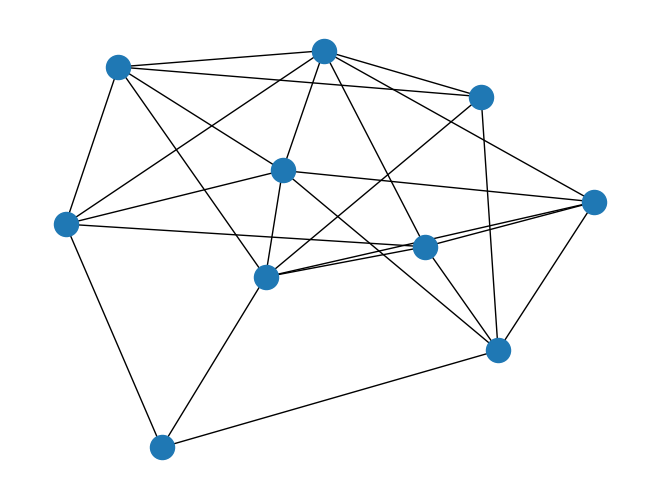

In [5]:

rail_network = rtc.RailNetwork(edges_df=edges_df,
                               edges_source_id_col='source',
                               edges_target_id_col='target',
                               edges_weight_col='length',
                               edge_tag_cols=['edge_id'],
                               nodes_df=nodes_df,
                               node_id_col='node_id',
                               node_tag_cols=['latitude','longitude'])
# Test some random functions to sanity check the test graph.
nx.draw(rail_network.rail_network_graph)
path = rail_network.compute_route(nodes_df.node_id[0], nodes_df.node_id[1])
print(f'Shortest path: {path}')
try:
    rail_network.get_segment_length_m(path[-1], path[0])
except AssertionError:
    print("Successfully detected ege not in graph!")
try:
    rail_network.get_segment_length_m(path[0], path[1])
except AssertionError:
    print("Incorrect assertion error, edge is in graph...")

## Creating agents

### Rail Terminals

In [6]:
# For now, put the terminals at the first and last node IDs in the RailNetwork.
cordele_node_id = nodes_df['node_id'].iloc[0]
savannah_node_id = nodes_df['node_id'].iloc[-1]

# Create RailTerminal in Savannah.
savannah_location = rtc.GeoLocation(
    latitude=32.0746968,
    longitude=-81.1218618,
    address="1880 W Gwinnett St, Savannah, GA 31415",
    rail_node_id=savannah_node_id
)
savannah_terminal = rtc.RailTerminal(
    env=env,
    name="Savannah Marine Terminal",
    location=savannah_location,
)

# Create RailTerminal in Cordele.
cordele_location = rtc.GeoLocation(
    latitude=31.968125,
    longitude=-83.7420403,
    address="2902 E 13th Ave, Cordele, GA 31015",
    rail_node_id=cordele_node_id
)

cordele_terminal = rtc.RailTerminal(
    env=env,
    name="Cordele Intermodal Services, Inc.",
    location=cordele_location,
)

rail_terminals = [savannah_terminal, cordele_terminal]

for terminal in rail_terminals:
    rail_network.register_terminal_at_node(terminal=terminal,
                                           node_id=terminal.get_location().get_rail_node_id())

print("Created terminals!")
for t in rail_terminals:
    print('='*50)
    print(f'{t}')
    print('='*50)

Created terminals!
Name: Savannah Marine Terminal
Location: 1880 W Gwinnett St, Savannah, GA 31415
with rail node ID: 9
arrival payload count: 0
departure payload count: 0
Name: Cordele Intermodal Services, Inc.
Location: 2902 E 13th Ave, Cordele, GA 31015
with rail node ID: 0
arrival payload count: 0
departure payload count: 0


#### Terminal Debugging

In [7]:
# Test that the RailTerminals can be mutated both through the RailNetwork and the RailTerminal
# instances.

# Print initial state of terminal.
print('='*50)
print("INITIAL")
print('='*50)
print(f"{savannah_terminal}")
print('='*50)
# Put something in the RailTerminal arrival queue directly, show statistics reported by both references.
print("PUTTING ONE VIA TERMINAL...")
print('='*50)
savannah_terminal.arrival_queue.put(1)
print(f"{savannah_terminal}")
print('='*50)
print(f"{rail_network.rail_network_graph.nodes[savannah_node_id]['Terminal']}")
assert len(savannah_terminal.arrival_queue.items) == len(rail_network.rail_network_graph.nodes[savannah_node_id]['Terminal'].arrival_queue.items)

print('='*50)
print("REMOVING ONE VIA GRAPH...")
print('='*50)
# Remove something
rail_network.rail_network_graph.nodes[savannah_node_id]['Terminal'].arrival_queue.get()
print('='*50)
print(f"{savannah_terminal}")
print('='*50)
print(f"{rail_network.rail_network_graph.nodes[savannah_node_id]['Terminal']}")
assert len(savannah_terminal.arrival_queue.items) == len(rail_network.rail_network_graph.nodes[savannah_node_id]['Terminal'].arrival_queue.items)

# Check if we can find it with our querying function.
assert isinstance(rail_network.check_for_rail_terminal(savannah_node_id), rtc.RailTerminal), "Should have extracted Savannah terminal!"
assert rail_network.check_for_rail_terminal(cordele_node_id+1) is None, "Should have NOT found a terminal!"

INITIAL
Name: Savannah Marine Terminal
Location: 1880 W Gwinnett St, Savannah, GA 31415
with rail node ID: 9
arrival payload count: 0
departure payload count: 0
PUTTING ONE VIA TERMINAL...
Name: Savannah Marine Terminal
Location: 1880 W Gwinnett St, Savannah, GA 31415
with rail node ID: 9
arrival payload count: 1
departure payload count: 0
Name: Savannah Marine Terminal
Location: 1880 W Gwinnett St, Savannah, GA 31415
with rail node ID: 9
arrival payload count: 1
departure payload count: 0
REMOVING ONE VIA GRAPH...
Name: Savannah Marine Terminal
Location: 1880 W Gwinnett St, Savannah, GA 31415
with rail node ID: 9
arrival payload count: 0
departure payload count: 0
Name: Savannah Marine Terminal
Location: 1880 W Gwinnett St, Savannah, GA 31415
with rail node ID: 9
arrival payload count: 0
departure payload count: 0


### Container Yards

In [8]:
# Create container yards using spreadsheet data from Marty and Mary.
container_yards_df = gpd.read_file('./data/SavannahCordeleNbrs.geojson')

REQUESTS_PER_DAY = 1.5

# Helper function for converting the geoJSON file to ContainerYard objects
def create_container_yard(container_yard: gpd.GeoSeries) -> rtc.ContainerYard:
    yard_location = rtc.GeoLocation(latitude=container_yard[['LATITUDE']].item(),
                                longitude=container_yard[['LONGITUDE']].item(),
                                address=container_yard[['Address']].item())
    return rtc.ContainerYard(env=env,
                        requests_per_day=REQUESTS_PER_DAY,
                        name=container_yard[['Corp Name']].item(),
                        location=yard_location)

container_yards = container_yards_df.apply(create_container_yard, axis=1).tolist()

print("Created container yards!")
for c in container_yards:
    print('='*50)
    print(f'{c}')
    print('='*50)
    

Created container yards!
Name: CORDELE INTERMODAL SERVICES
Location: P.O. BOX 876
Number of received containers:0
Name: XPO - OGLETHORPE
Location: 238 STAGECOACH ROAD
Number of received containers:0
Name: Blue Bird Corp
Location: 402 Bluebird Blvd
Number of received containers:0
Name: Perdue Farms
Location: 250 Georgia Highway 247 Spur
Number of received containers:0
Name: Orgill, Inc.
Location: 260 Jordan Rd
Number of received containers:0


### Trucks

In [9]:
# Create a set of trucks stationed at each container yard, leaving for Cordele.
TRUCK_CAPACITY = 2
trucks = []
for i, container_yard in enumerate(container_yards):
    trucks.append(rtc.Truck(env=env,
                        vehicle_id=i,
                        capacity=TRUCK_CAPACITY,
                        current_location=container_yard,
                        current_payload=None,
                        current_destination=cordele_terminal))

# Check that we can print out and see the trucks.
print("Created trucks!")
for t in trucks:
    print('='*50)
    print(f'{t}')
    print('='*50)

Created trucks!
Truck 0
At location: CORDELE INTERMODAL SERVICES
Empty
Going to: Cordele Intermodal Services, Inc.
Truck 1
At location: XPO - OGLETHORPE
Empty
Going to: Cordele Intermodal Services, Inc.
Truck 2
At location: Blue Bird Corp
Empty
Going to: Cordele Intermodal Services, Inc.
Truck 3
At location: Perdue Farms
Empty
Going to: Cordele Intermodal Services, Inc.
Truck 4
At location: Orgill, Inc.
Empty
Going to: Cordele Intermodal Services, Inc.


### Parallel Vehicles

In [10]:
# Create ParallelVehicle instances

# How many Parallel vehicles will we simulate?
NUM_PARALLEL_VEHICLES = 1

# How many payloads can each vehicle carry?
PARALLEL_VEHICLE_CAPACITY = 12

# Create all of the vehicles
parallel_vehicles = []
for i in range(NUM_PARALLEL_VEHICLES):
    parallel_vehicles.append(rtc.ParallelVehicle(env=env,
                                                 vehicle_id=i,
                                                 capacity=PARALLEL_VEHICLE_CAPACITY,
                                                 rail_network=rail_network,
                                                 current_rail_node_id=savannah_node_id,
                                                 current_route=None,
                                                 destination=cordele_terminal,
                                                 current_payload=None
                                                 ))
print('Generated Parallel vehicles!')
for p in parallel_vehicles:
    print('='*50)
    print(f'{p}')
    print('='*50)

Generated Parallel vehicles!
Parallel Vehicle 0
At rail terminal: Savannah Marine Terminal
At rail ID: 9
Going to: Cordele Intermodal Services, Inc.


In [18]:
pv = parallel_vehicles[0]
next(pv.put_payload(1))
next(pv.get_payload())

StopIteration: 

### Registering Agents with the Sim

In [10]:
# Add event generators for Payload request generation
for container_yard in container_yards:
    env.process(container_yard.run(savannah_terminal))

# Add event generators for Parallel vehicle actions
for parallel_vehicle in parallel_vehicles:
    env.process(parallel_vehicle.run())

# Add event generators for Truck actions
for truck in trucks:
    env.process(truck.run())

## Running!

In [8]:
# Run that bad boy for some days!
DAYS_TO_RUN = 365
time_to_run_hrs = DAYS_TO_RUN*24

env.run(until=time_to_run_hrs)

T = 0.000 | Parallel vehicle leaving Savannah Marine Terminal with 0 payloads
T = 0.000 | Truck 0 departing CORDELE INTERMODAL SERVICES for Cordele Intermodal Services, Inc.
T = 0.000 | Truck 1 departing XPO - OGLETHORPE for Cordele Intermodal Services, Inc.
T = 0.000 | Truck 2 departing Blue Bird Corp for Cordele Intermodal Services, Inc.
T = 0.000 | Truck 3 departing Perdue Farms for Cordele Intermodal Services, Inc.
T = 0.000 | Truck 4 departing Orgill, Inc. for Cordele Intermodal Services, Inc.
T = 0.808 | Truck 1 arrived at Cordele Intermodal Services, Inc.
T = 1.464 | Truck 3 arrived at Cordele Intermodal Services, Inc.
T = 2.073 | Truck 4 arrived at Cordele Intermodal Services, Inc.
T = 2.280 | Truck 0 arrived at Cordele Intermodal Services, Inc.
T = 2.537 | Truck 2 arrived at Cordele Intermodal Services, Inc.
T = 9.117 | Container yard Blue Bird Corp generated a new order at Savannah Marine Terminal.
T = 9.744 | Container yard CORDELE INTERMODAL SERVICES generated a new order a

# Reporting simulation outputs

## Extracting and saving states

In [9]:
import os
output_directory = './output'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

In [10]:
# First, report locations of fixed objects

# Wildly inefficient, don't judge me too hard
def static_object_list_to_parquet(list_inputs, dest_filename):
    """
    Helper function to take a list of things that have both `name` (str) and
    `location` (GeoLocation) attributes and dump them into a .parquet file.

    Returns the dataframe, in case you are interested in it still.
    """
    df = pd.DataFrame.from_dict({'NAME': [thing.name for thing in list_inputs],
                                 'LATITUDE': [thing.location.latitude for thing in list_inputs],
                                 'LONGITUDE': [thing.location.longitude for thing in list_inputs]})
    df.to_parquet(dest_filename)
    return df

# Dump the container yards and terminals into CSVs
container_yard_locations = static_object_list_to_parquet(container_yards, os.path.join(output_directory, 'container_yard_locations.parquet'))
rail_terminal_locations = static_object_list_to_parquet(rail_terminals, os.path.join(output_directory, 'rail_terminal_locations.parquet'))

In [11]:
# Next, we'll report a time-series of the ParallelVehicle's locations at each step of its process.
# TODO: (@ps-jbunton) should consider using pandas built in date-time processing
# TODO: (@ps-jbunton) should do mapping of intermediate values depending on reported quantity

WINDOW_SIZE_HRS = 0.5
    

def dynamic_object_list_to_parquet(list_objects, dest_dir):
    """
    Helper function that takes a list of objects that have either an `id` or
    `name` attribute and a `reporting_list` attribute and dumps them into a dict
    that maps from `name`/`id` to a pandas DataFrame, saving each dataframe in a
    .parquet file.

    Also returns the keyed dictionary of dataframes, just in case you need it.
    """
    reports = {}
    for object in list_objects:
        if hasattr(object, 'name'):
            key = object.name
        elif hasattr(object, 'vehicle_id'):
            key = object.vehicle_id
        
        reports[key] = pd.DataFrame.from_records(object.reporting_list).ffill().bfill().groupby(by='TIME', as_index=False).first()
        reports[key].index = pd.to_timedelta(reports[key]['TIME'], unit='hours')
    
    for (key, report) in reports.items():
        report.to_parquet(dest_dir+f'{key}.parquet')
    return reports

parallel_vehicle_outputs = dynamic_object_list_to_parquet(parallel_vehicles, os.path.join(output_directory, 'parallel_vehicle_'))
container_yard_outputs = dynamic_object_list_to_parquet(container_yards, os.path.join(output_directory, 'container_yard_'))
rail_terminal_outputs = dynamic_object_list_to_parquet(rail_terminals, os.path.join(output_directory, 'rail_terminal_'))
truck_outputs = dynamic_object_list_to_parquet(trucks, os.path.join(output_directory, 'truck_'))

# Computing rolling average quantities.
rail_terminal_outputs['Cordele Intermodal Services, Inc.']['ARRIVAL_QUEUE_SIZE_AVG'] = rail_terminal_outputs['Cordele Intermodal Services, Inc.']['ARRIVAL_QUEUE_SIZE'].expanding().mean()/rail_terminal_outputs['Cordele Intermodal Services, Inc.']['TIME']
rail_terminal_outputs['Savannah Marine Terminal']['DEPARTURE_QUEUE_SIZE_AVG'] = rail_terminal_outputs['Savannah Marine Terminal']['DEPARTURE_QUEUE_SIZE'].expanding().mean()/rail_terminal_outputs['Savannah Marine Terminal']['TIME']

## Static visualization

### Quick peek at dataframes

In [12]:
parallel_vehicle_outputs[0].head(10)

,TIME,LATITUDE,LONGITUDE,CURRENT_LOAD
TIME,,,,
0 days 00:00:00,0.000000,32.074697,-81.121862,0
0 days 10:32:12.254731944,10.536737,31.968125,-83.742040,0
0 days 15:42:15.800339098,15.704389,32.074697,-81.121862,0
0 days 16:07:23.079289036,16.123078,32.074697,-81.121862,1
0 days 20:42:00.987754633,20.700274,32.074697,-81.121862,2
0 days 21:26:40.159455284,21.444489,32.074697,-81.121862,3
1 days 06:27:29.841080612,30.458289,32.074697,-81.121862,4
1 days 18:13:53.961729751,42.231656,32.074697,-81.121862,5
1 days 21:03:45.537427076,45.062649,32.074697,-81.121862,6


In [13]:
import numpy as np

# Pull a timeseries for testing
test_df = parallel_vehicle_outputs[0]
test_df.head(10)

# Getting there! The "limit" command on nearest seems to be our best bet since
# it prevents us from doing too much forward/back filling.  The downside here is
# that it `snaps` the state to the nearest two un-marked times in the regular
# grid.
smallest_dt = test_df.TIME.diff().min()*60*60
print(f'Smallest dt: {smallest_dt} s')
new_test_df = test_df.resample('1s').nearest(limit=1).interpolate().resample('1h').asfreq()
new_test_df.head(60)

Smallest dt: 1.2533167755464092 s


,TIME,LATITUDE,LONGITUDE,CURRENT_LOAD
TIME,,,,
0 days 00:00:00,0.000000,32.074697,-81.121862,0.000000
0 days 01:00:00,0.999755,32.064585,-81.370472,0.000000
0 days 02:00:00,1.999788,32.054470,-81.619151,0.000000
0 days 03:00:00,2.999821,32.044356,-81.867830,0.000000
0 days 04:00:00,3.999855,32.034241,-82.116509,0.000000
0 days 05:00:00,4.999888,32.024126,-82.365188,0.000000
0 days 06:00:00,5.999921,32.014012,-82.613867,0.000000
0 days 07:00:00,6.999954,32.003897,-82.862546,0.000000
0 days 08:00:00,7.999987,31.993782,-83.111225,0.000000


In [14]:
rail_terminal_outputs['Savannah Marine Terminal'].head(10)

,TIME,ARRIVAL_QUEUE_SIZE,DEPARTURE_QUEUE_SIZE,DEPARTURE_QUEUE_SIZE_AVG
TIME,,,,
0 days 15:42:15.800339098,15.704389,0,2,0.127353
0 days 16:07:23.079289036,16.123078,0,1,0.093034
0 days 20:42:00.987754633,20.700274,0,0,0.048309
1 days 02:41:11.737385134,26.686594,0,0,0.028104
1 days 13:22:55.565561931,37.382102,0,0,0.016050
1 days 20:42:04.964736474,44.701379,0,0,0.011185
1 days 22:05:58.370379702,46.099547,0,0,0.009297
2 days 08:20:48.338950902,56.346761,0,0,0.006655
2 days 17:54:46.745212795,65.912985,0,0,0.005057


In [15]:
container_yard_outputs['Blue Bird Corp'].head(10)

,TIME,RECEIVED
TIME,,
4 days 08:20:08.151941508,104.335598,1
4 days 19:17:39.833118067,115.294398,2
5 days 04:56:14.356246668,124.937321,3
7 days 08:19:43.648121712,176.328791,4
9 days 01:58:45.994273028,217.979443,5
9 days 09:24:30.336809810,225.408427,6
9 days 13:07:20.526011587,229.122368,7
11 days 00:06:18.720236440,264.105200,8
11 days 01:48:11.823518322,265.803284,9


### Quick static timeseries plots

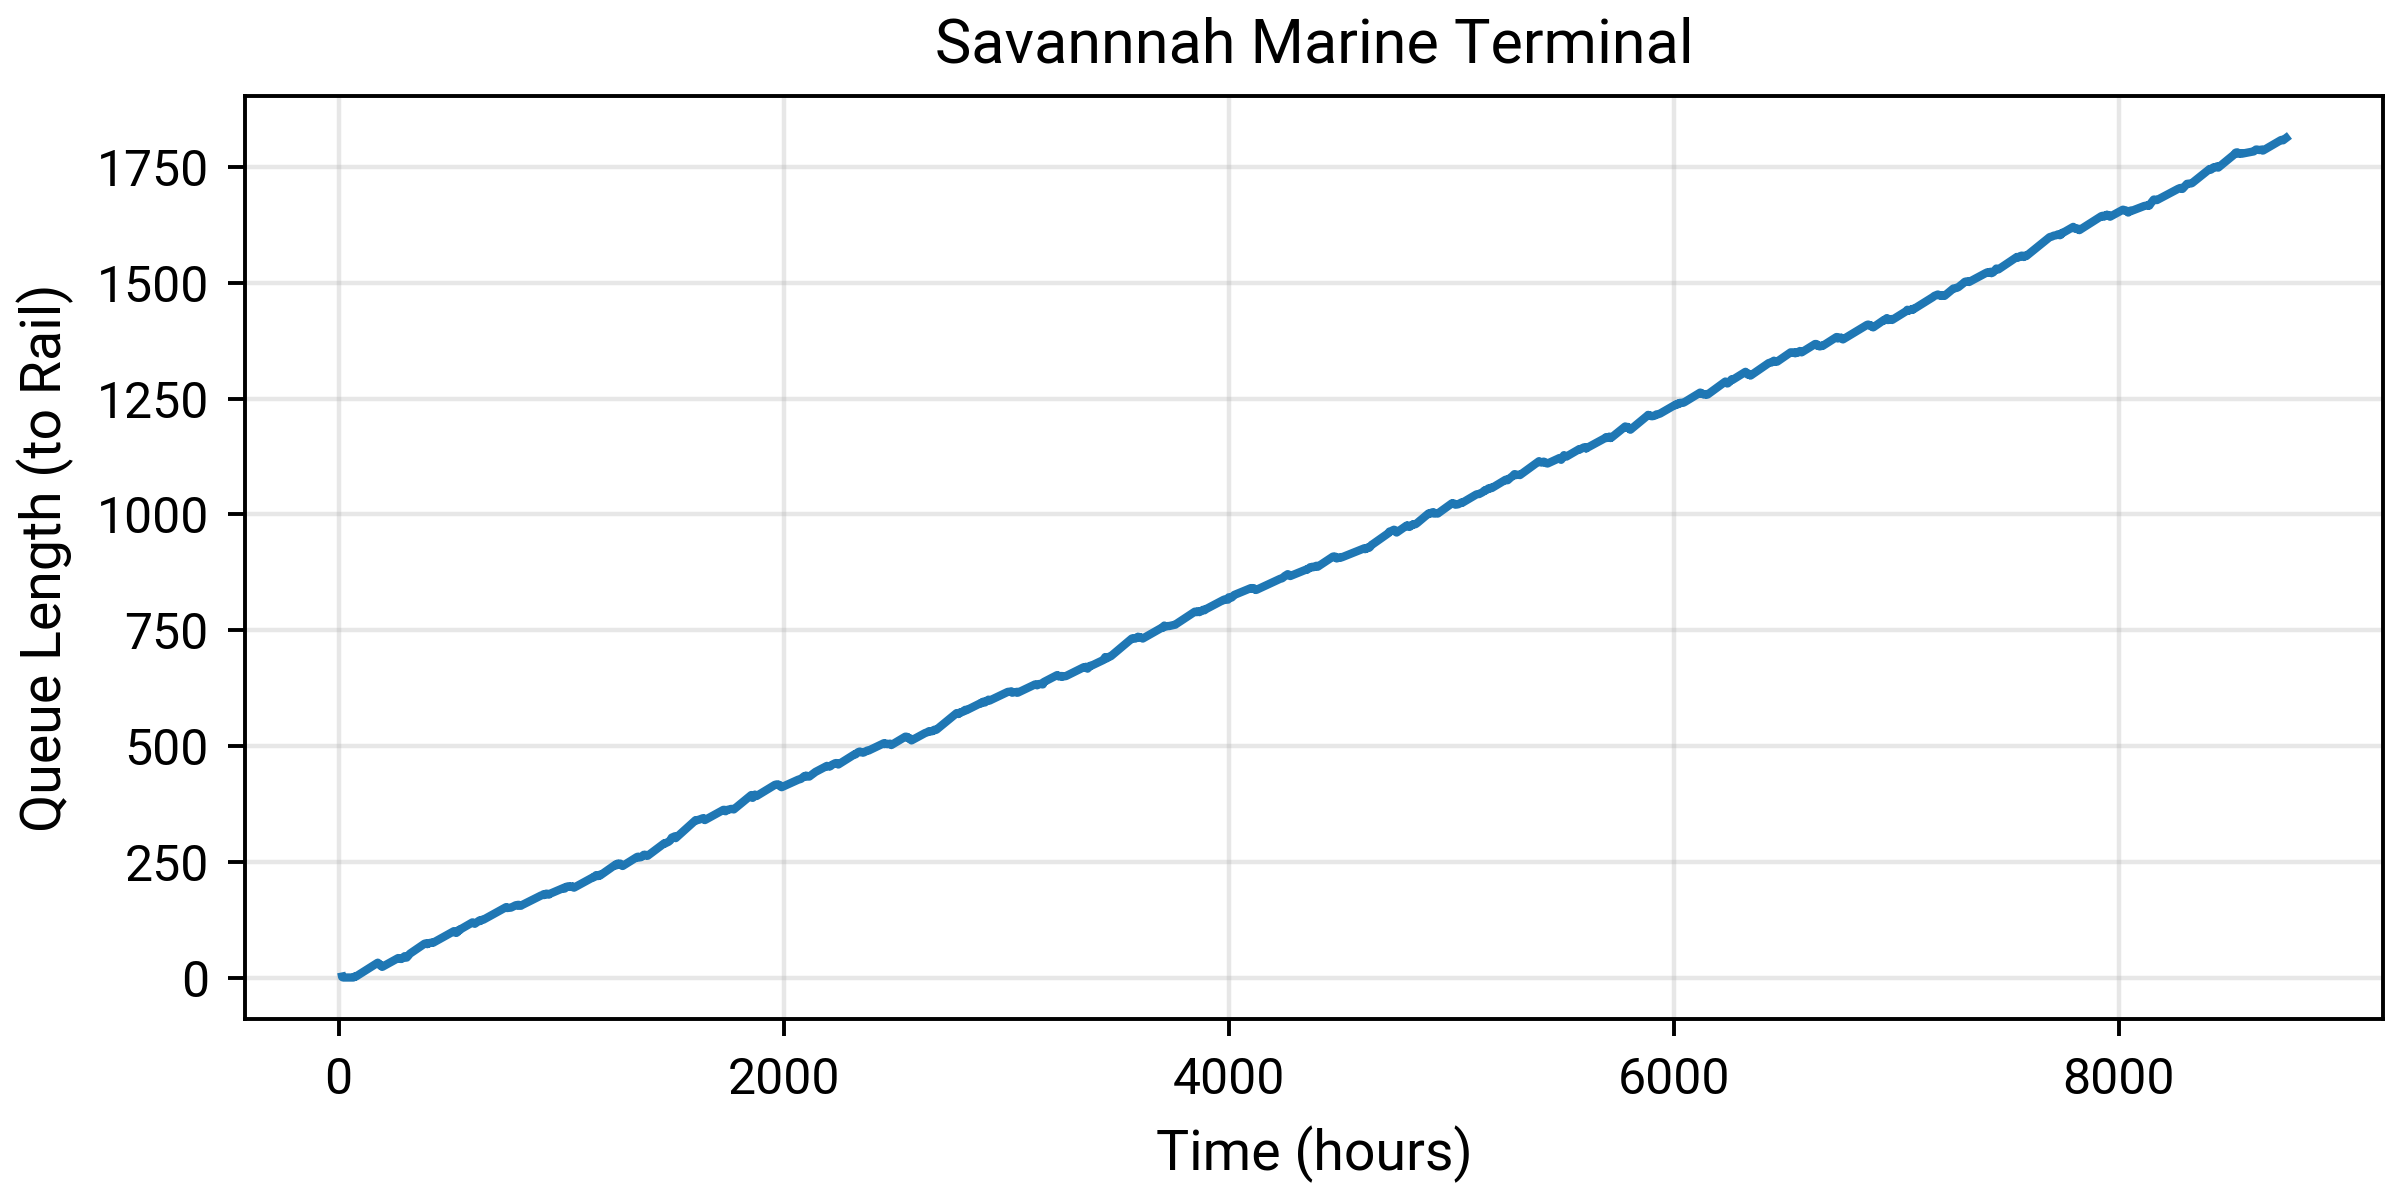

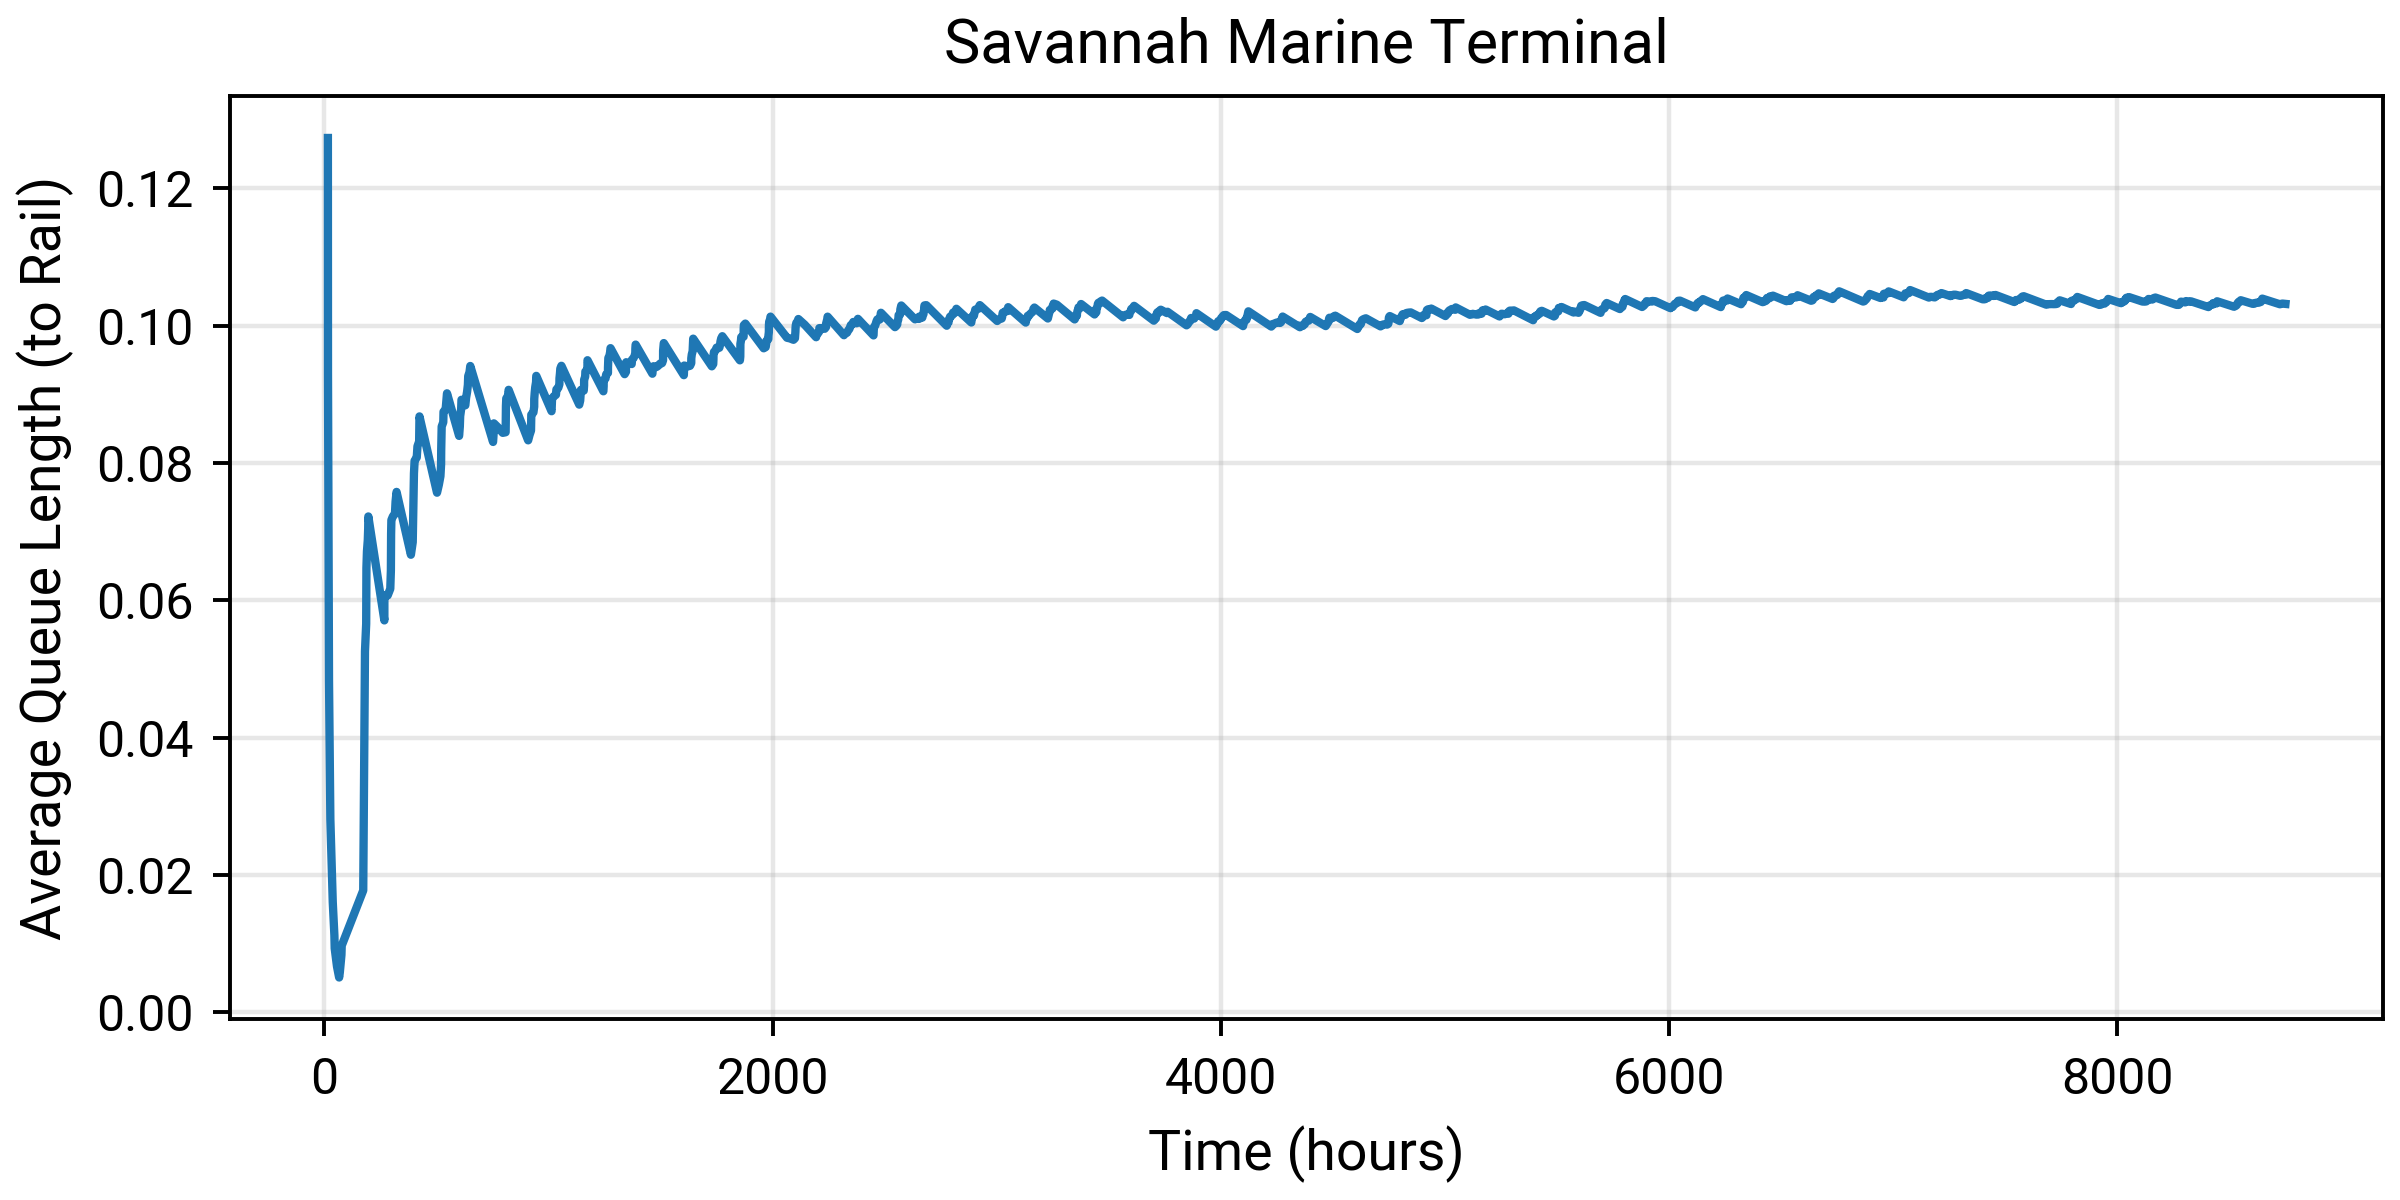

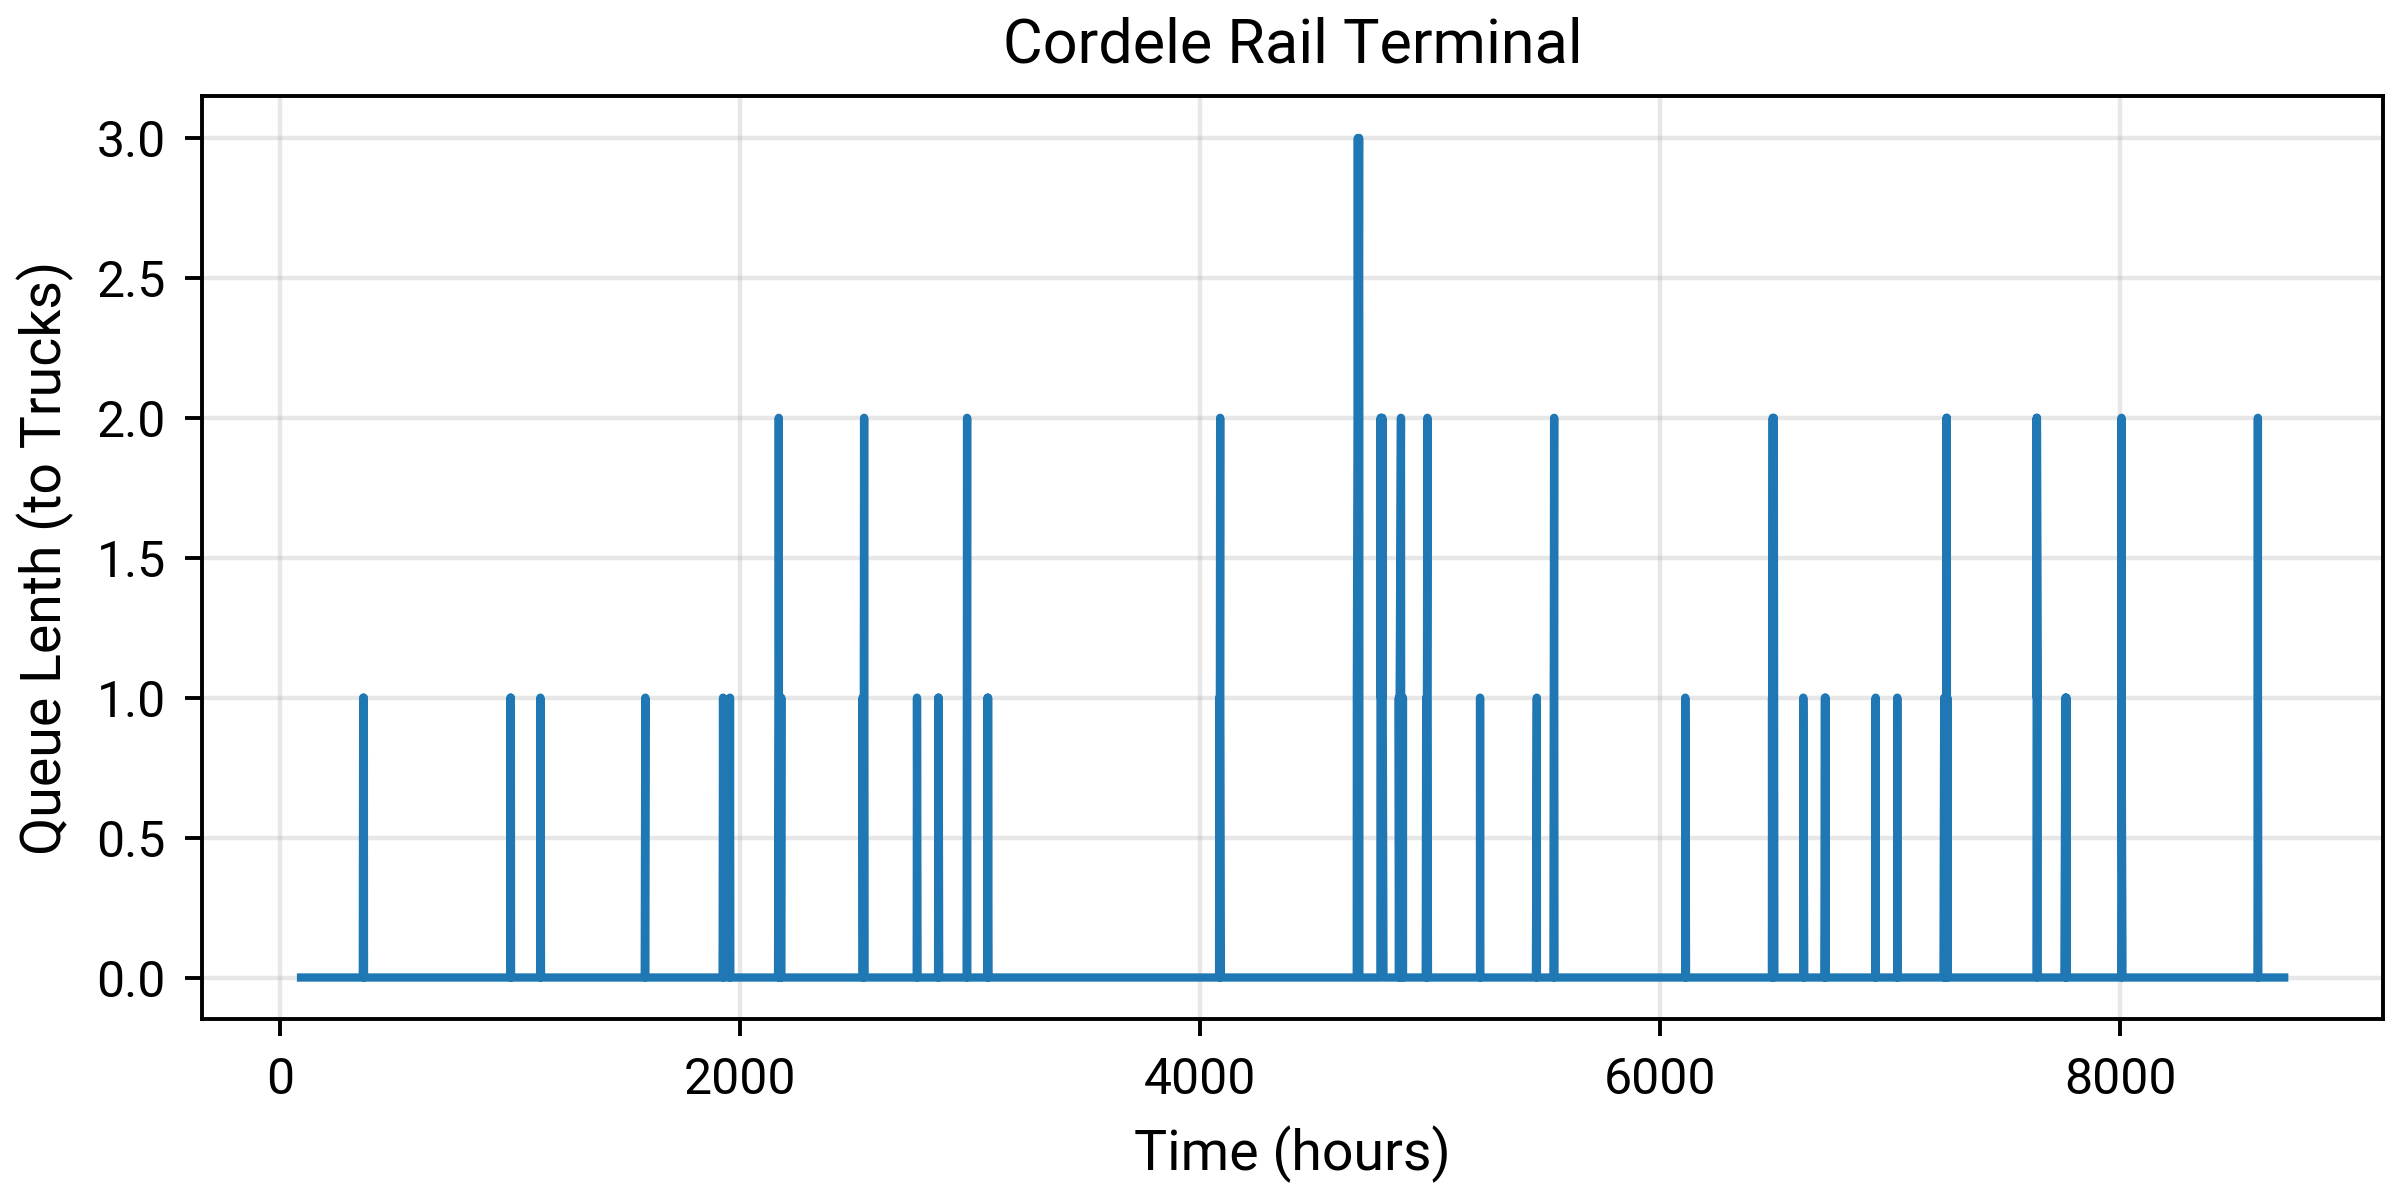

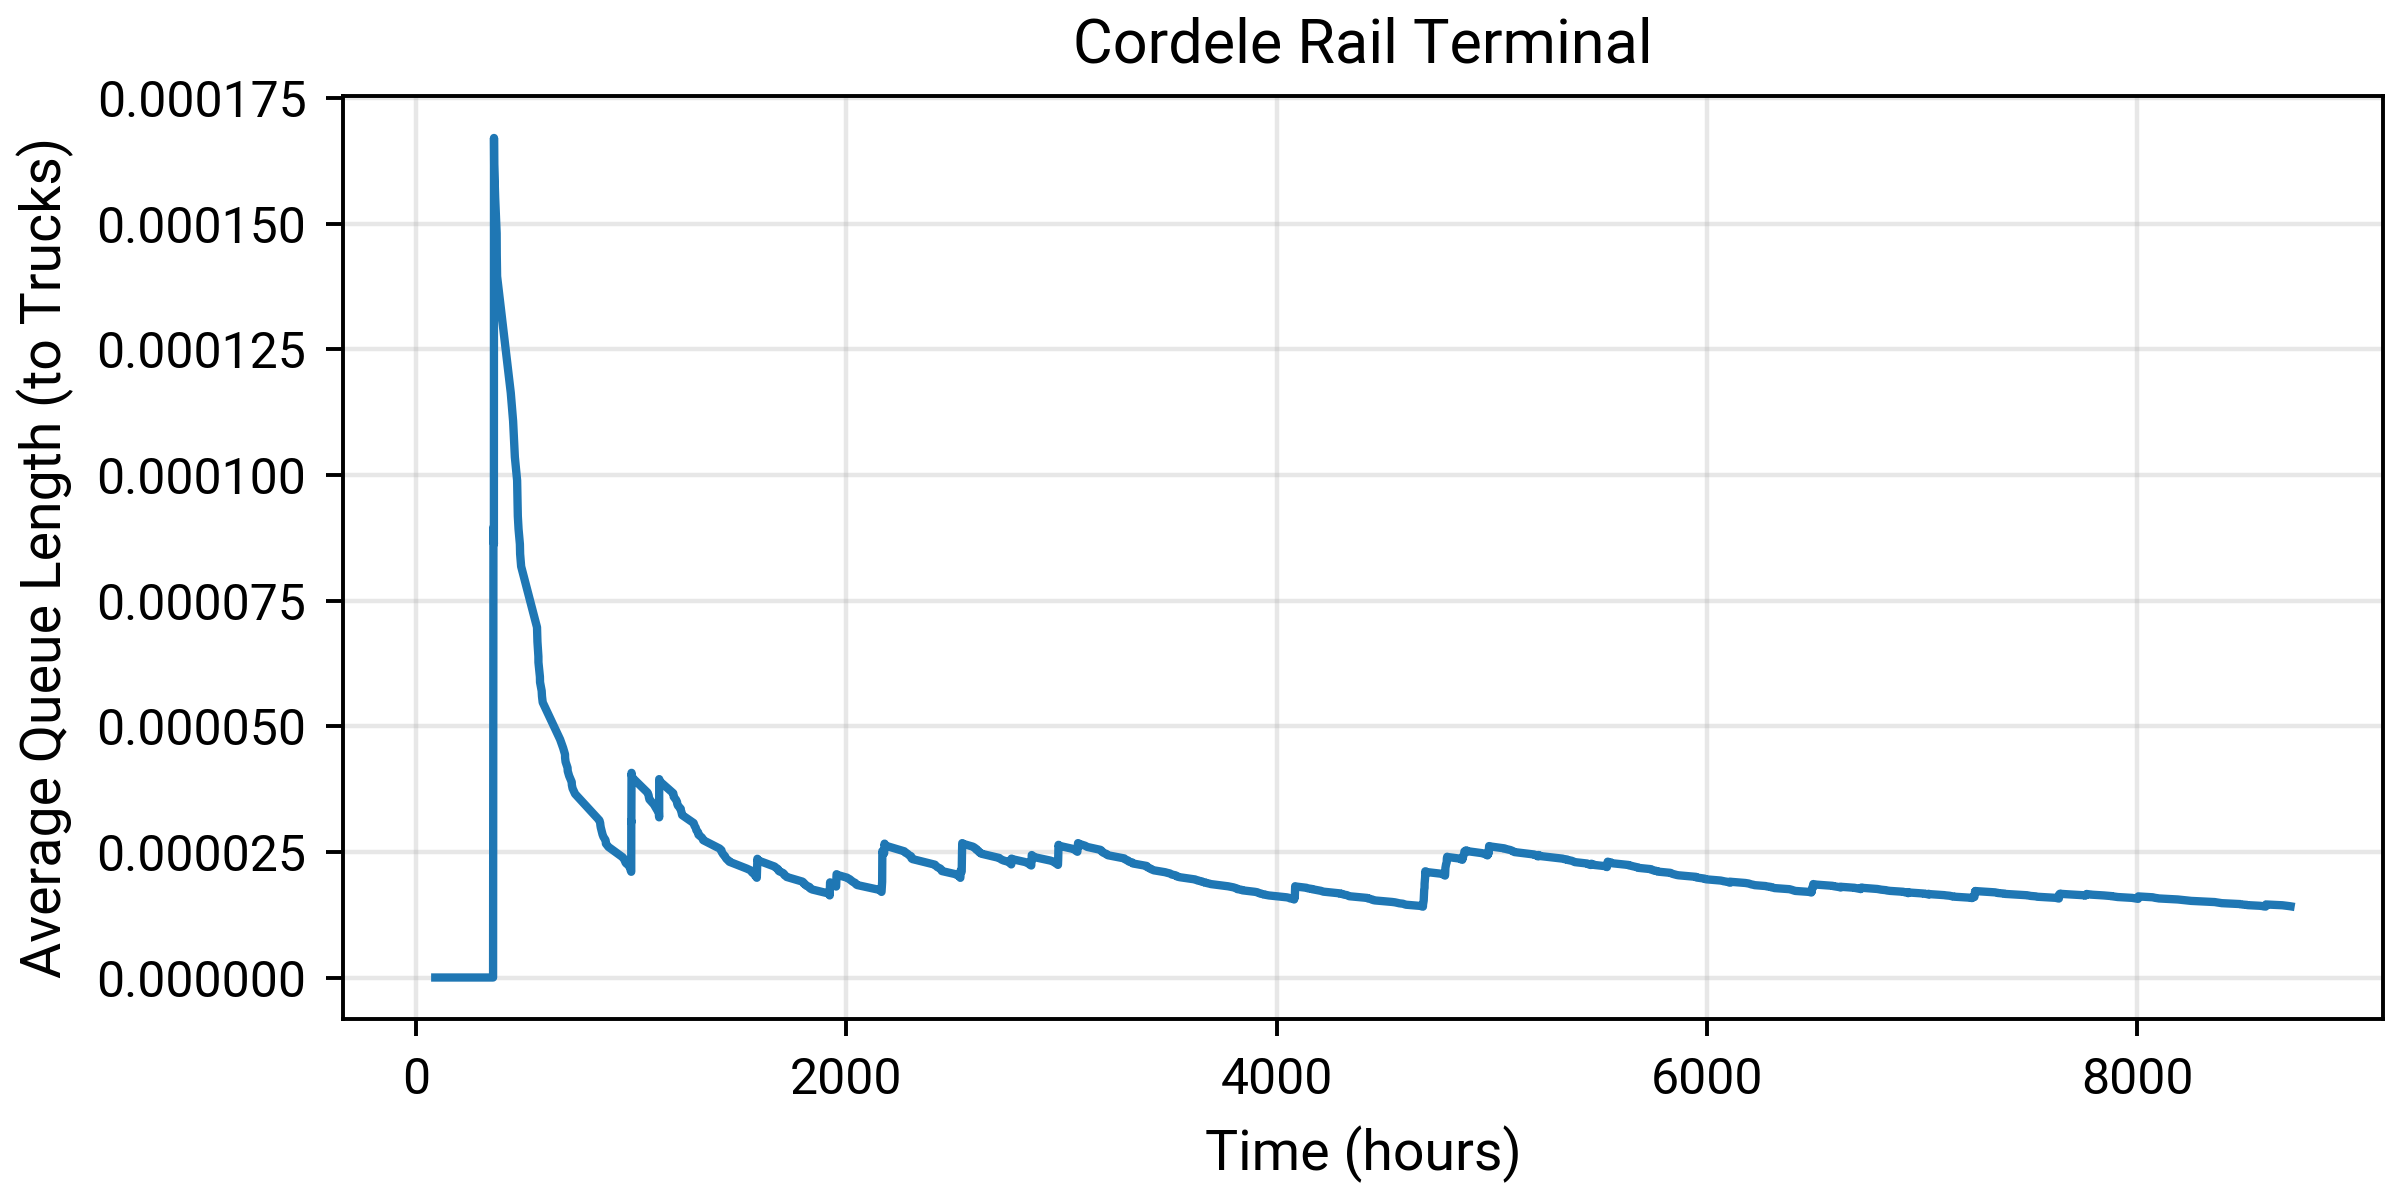

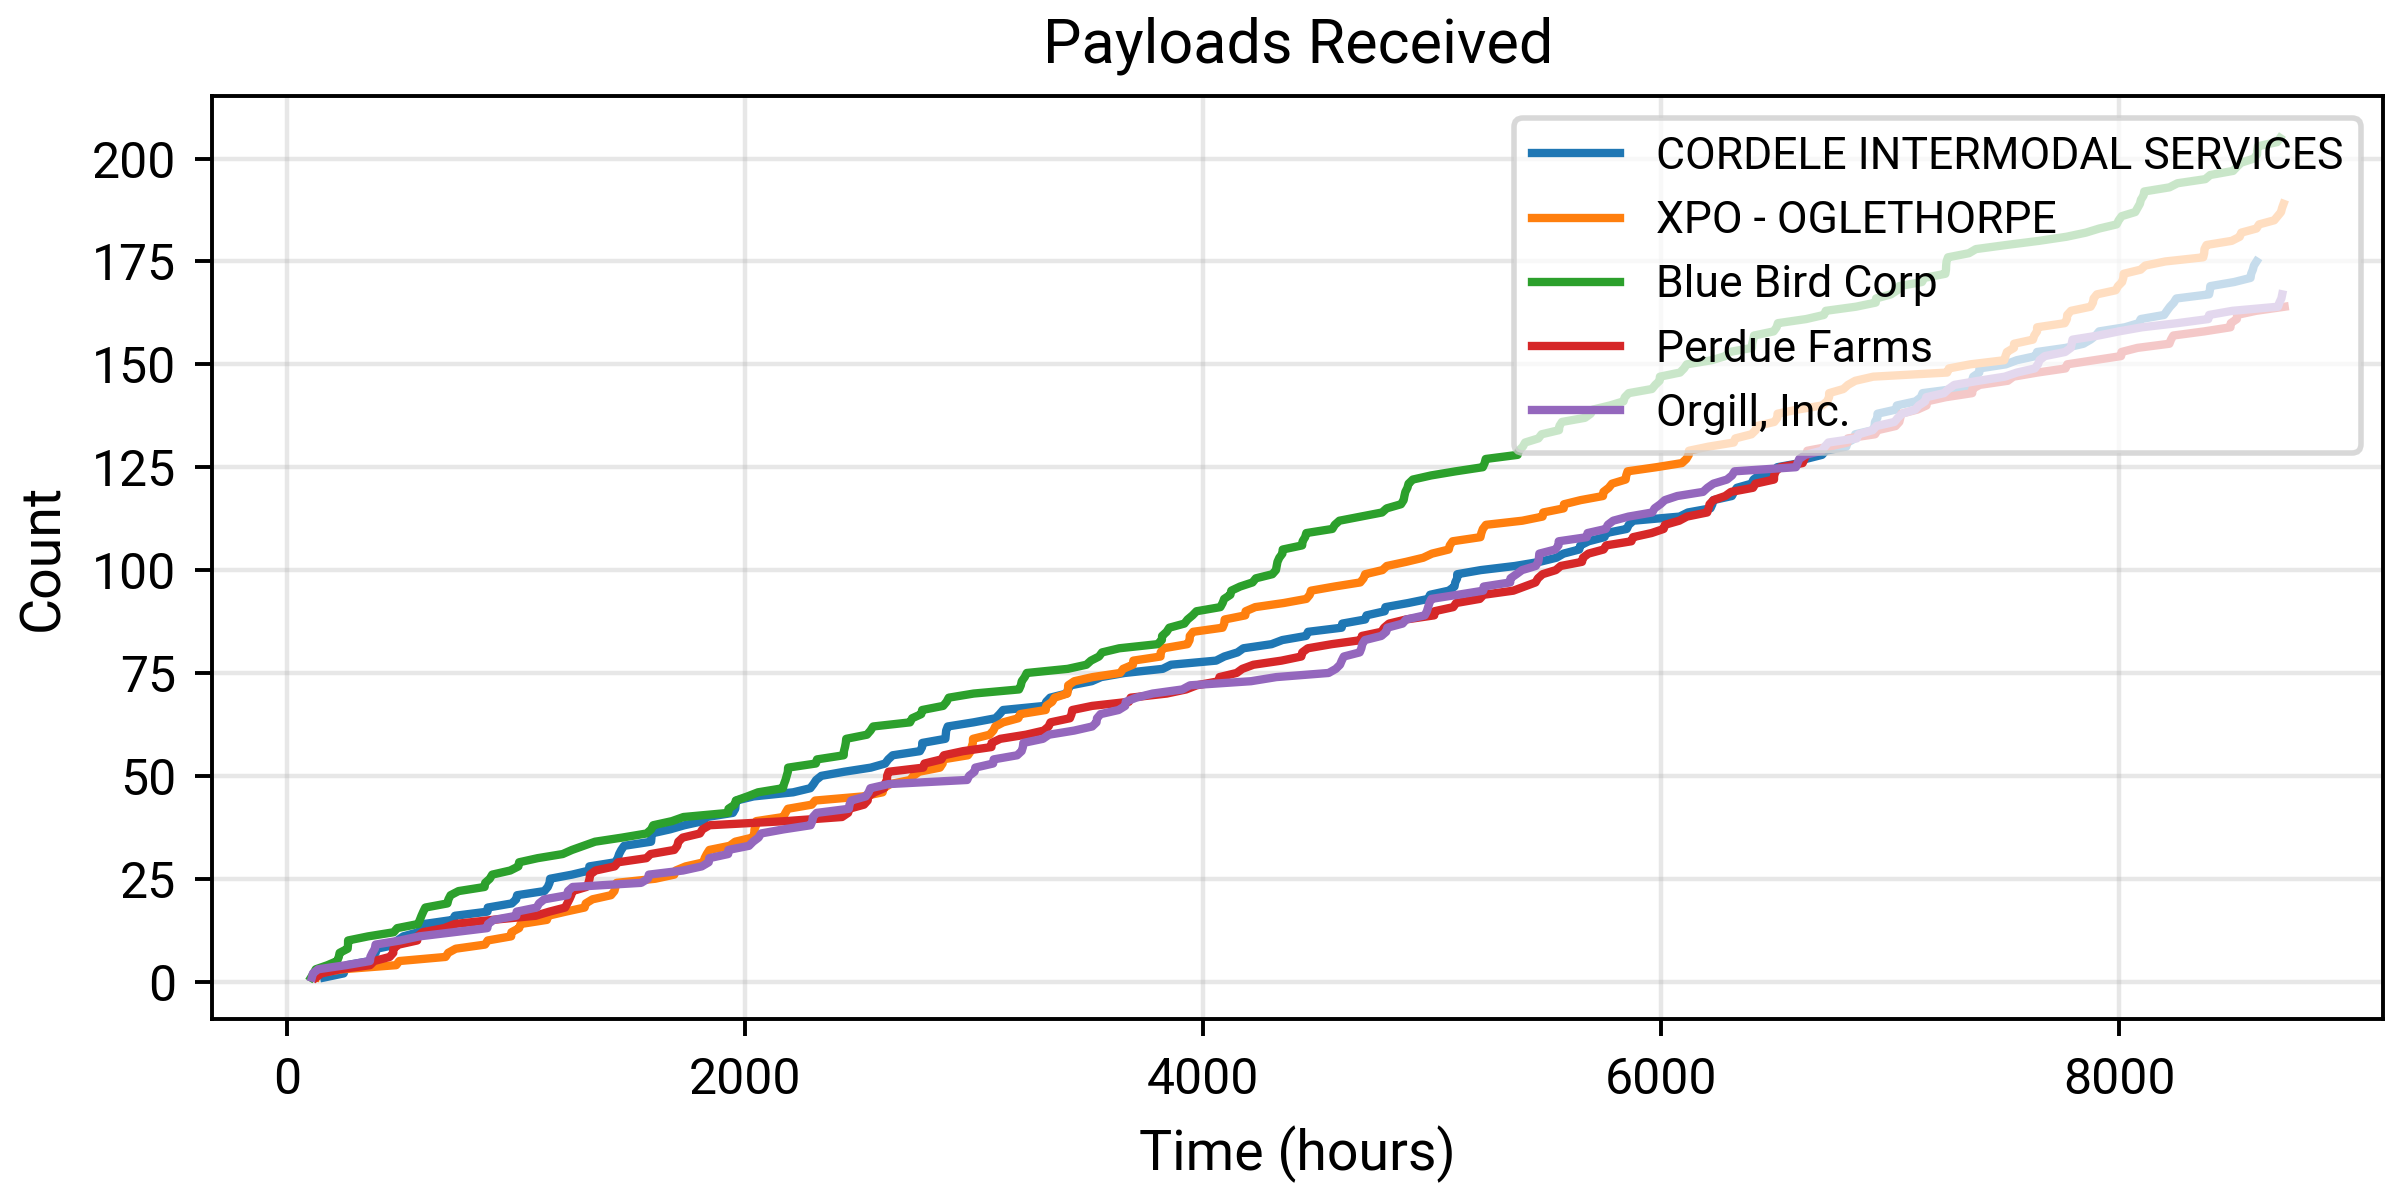

In [16]:
import contextplot

contextplot.set_defaults()

with contextplot.context_plot() as cp:
    cp.ax.plot(rail_terminal_outputs['Savannah Marine Terminal']['TIME'], rail_terminal_outputs['Savannah Marine Terminal']['DEPARTURE_QUEUE_SIZE'])
    cp.ax.set(xlabel='Time (hours)', ylabel='Queue Length (to Rail)', title='Savannnah Marine Terminal')

with contextplot.context_plot() as cp:
    cp.ax.plot(rail_terminal_outputs['Savannah Marine Terminal']['TIME'], rail_terminal_outputs['Savannah Marine Terminal']['DEPARTURE_QUEUE_SIZE_AVG'])
    cp.ax.set(xlabel='Time (hours)', ylabel='Average Queue Length (to Rail)', title='Savannah Marine Terminal')

with contextplot.context_plot() as cp:
    cp.ax.plot(rail_terminal_outputs['Cordele Intermodal Services, Inc.']['TIME'], rail_terminal_outputs['Cordele Intermodal Services, Inc.']['ARRIVAL_QUEUE_SIZE'])
    cp.ax.set(xlabel='Time (hours)', ylabel='Queue Lenth (to Trucks)', title='Cordele Rail Terminal')

with contextplot.context_plot() as cp:
    cp.ax.plot(rail_terminal_outputs['Cordele Intermodal Services, Inc.']['TIME'], rail_terminal_outputs['Cordele Intermodal Services, Inc.']['ARRIVAL_QUEUE_SIZE_AVG'])
    cp.ax.set(xlabel='Time (hours)', ylabel='Average Queue Length (to Trucks)', title='Cordele Rail Terminal')

with contextplot.context_plot() as cp:
    for name, results in container_yard_outputs.items():
        cp.ax.plot(results['TIME'], results['RECEIVED'], label=name)
        cp.ax.set(xlabel='Time (hours)', ylabel='Count')
    cp.ax.set(title='Payloads Received')
    _ = cp.ax_raw.legend()
    